In [ ]:
import pandas as pd
import datetime as dt
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from patsy import dmatrices
from pandas import Series
from matplotlib import pyplot
from datetime import datetime
from matplotlib.pyplot import figure

import statsmodels.api as sm

figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')

from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt

import sys
import warnings
import itertools
warnings.filterwarnings("ignore")

import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from statsmodels.tsa.stattools import adfuller


from statsmodels.tsa.arima_model import ARIMA

<Figure size 1280x960 with 0 Axes>

In [ ]:
df = pd.read_csv("/content/monthly-car-sales.csv")
df.head()

,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


In [ ]:
#Parse strings to datetime type
df['Month'] = pd.to_datetime(df['Month'],infer_datetime_format=True) #convert from string to datetime
df = df.set_index(['Month'])

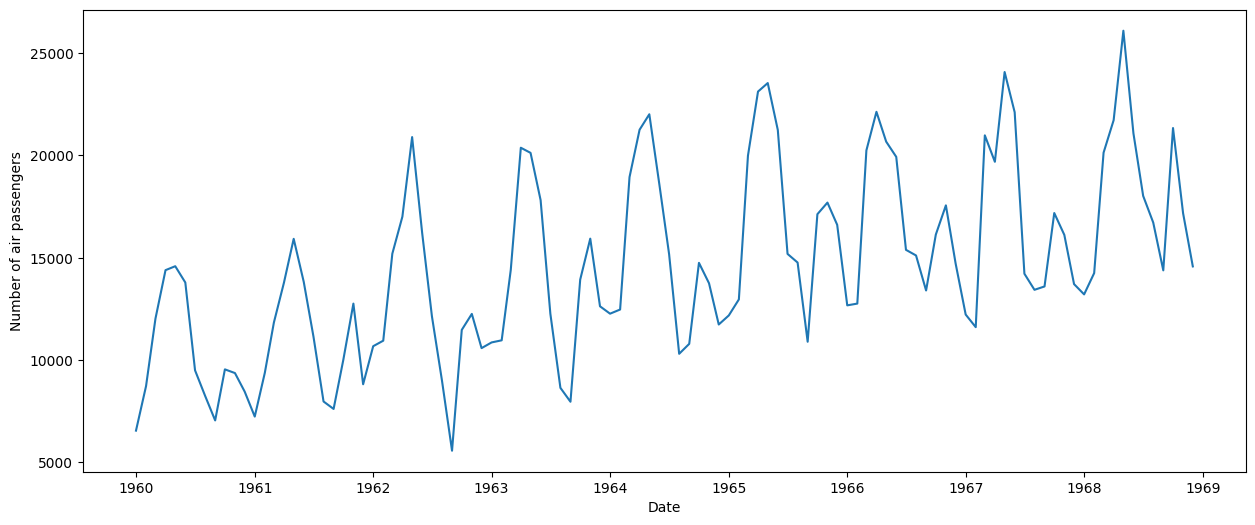

In [ ]:
## plot graph
plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.plot(df)

In [ ]:
#Test whether Timeseries is Stationary or not
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries['Sales'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

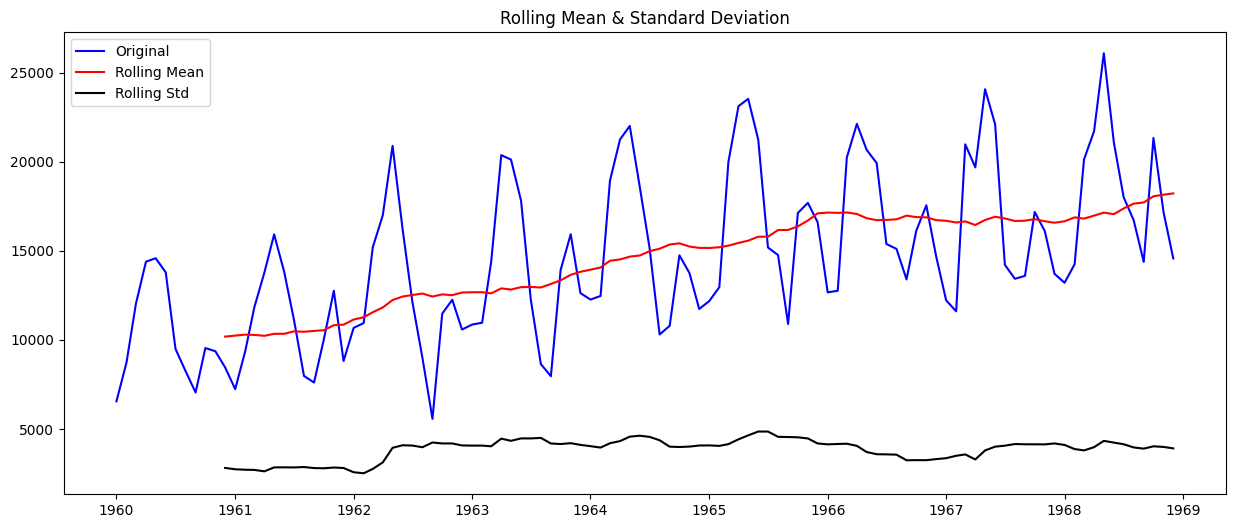

Results of Dickey-Fuller Test:
Test Statistic                 -1.223813
p-value                         0.663269
#Lags Used                     12.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64


In [ ]:
test_stationarity(df)

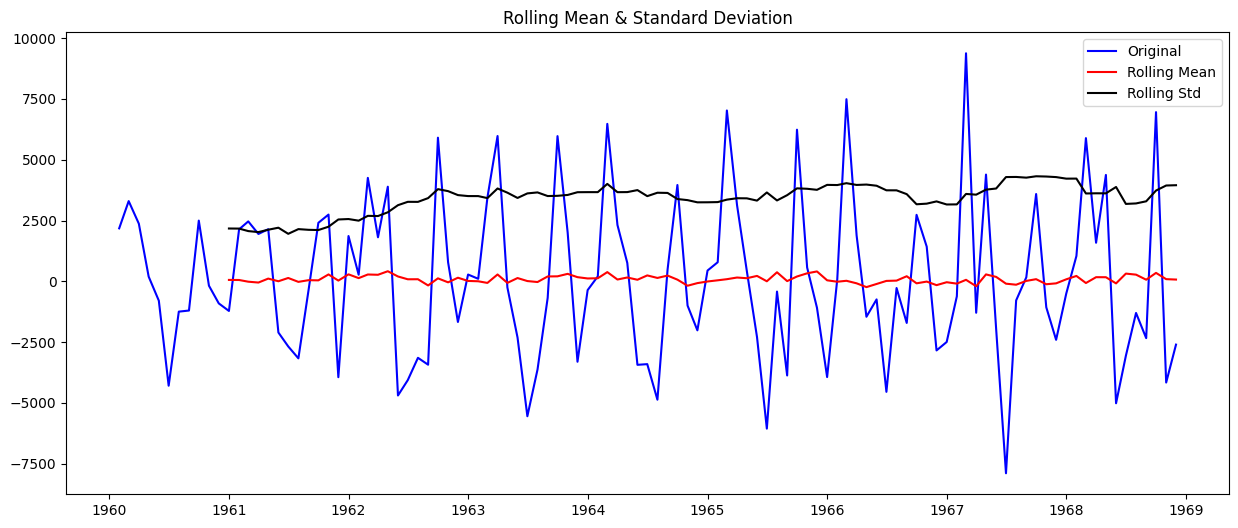

Results of Dickey-Fuller Test:
Test Statistic                -6.199799e+00
p-value                        5.844753e-08
#Lags Used                     1.100000e+01
Number of Observations Used    9.500000e+01
Critical Value (1%)           -3.501137e+00
Critical Value (5%)           -2.892480e+00
Critical Value (10%)          -2.583275e+00
dtype: float64


In [ ]:
diff_df = df.diff(periods=1)
diff_df.dropna(inplace=True)
test_stationarity(diff_df)

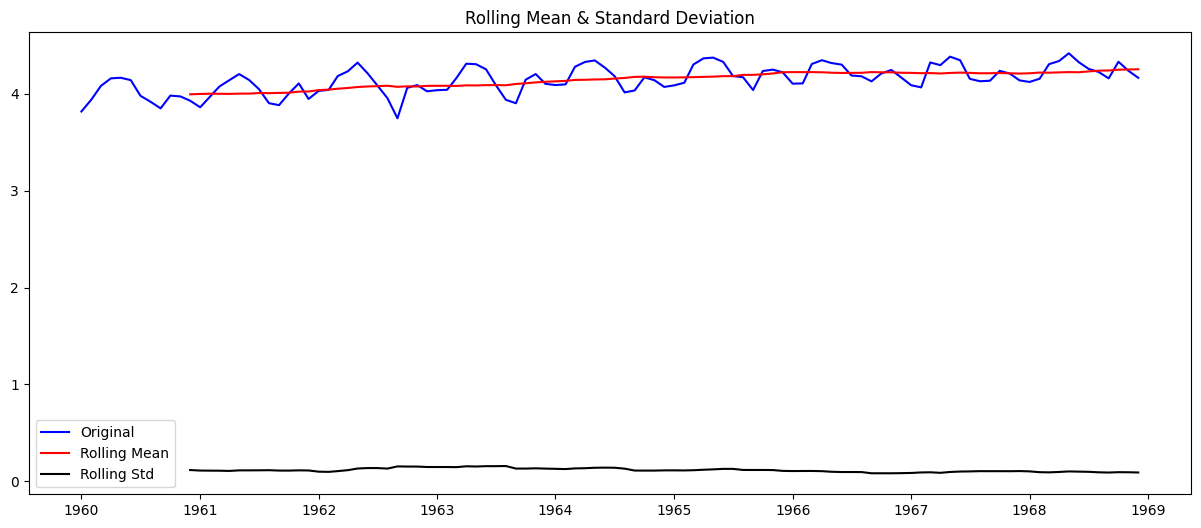

Results of Dickey-Fuller Test:
Test Statistic                 -1.452425
p-value                         0.556901
#Lags Used                     13.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64


In [ ]:
df_log = np.log10(df)
df_log.dropna(inplace=True)
test_stationarity(df_log)

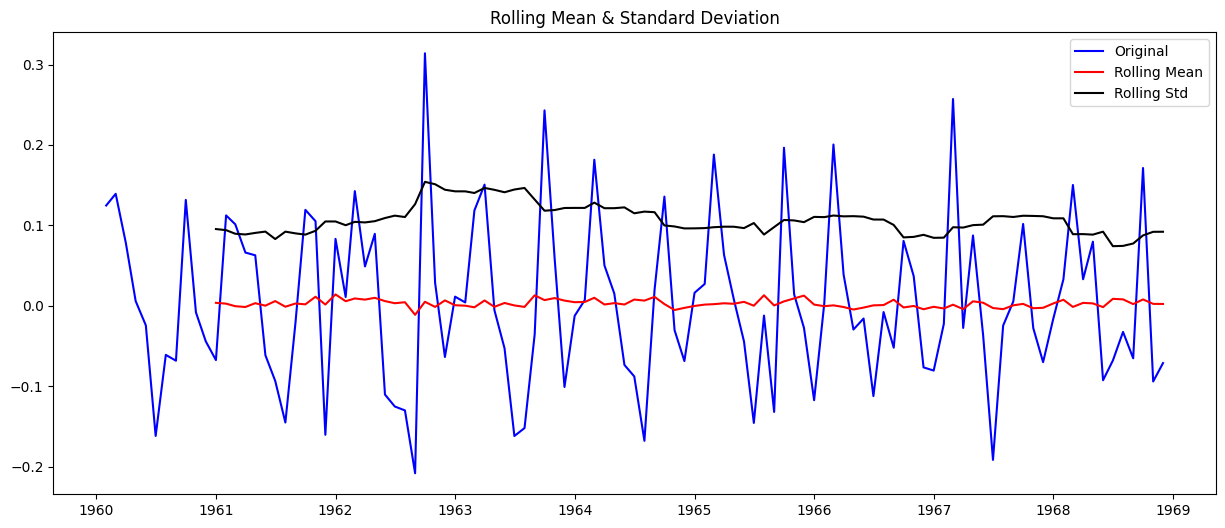

Results of Dickey-Fuller Test:
Test Statistic                 -4.193835
p-value                         0.000675
#Lags Used                     12.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64


In [ ]:
diff_log_df = df_log.diff(periods=1)
diff_log_df.dropna(inplace=True)
test_stationarity(diff_log_df)

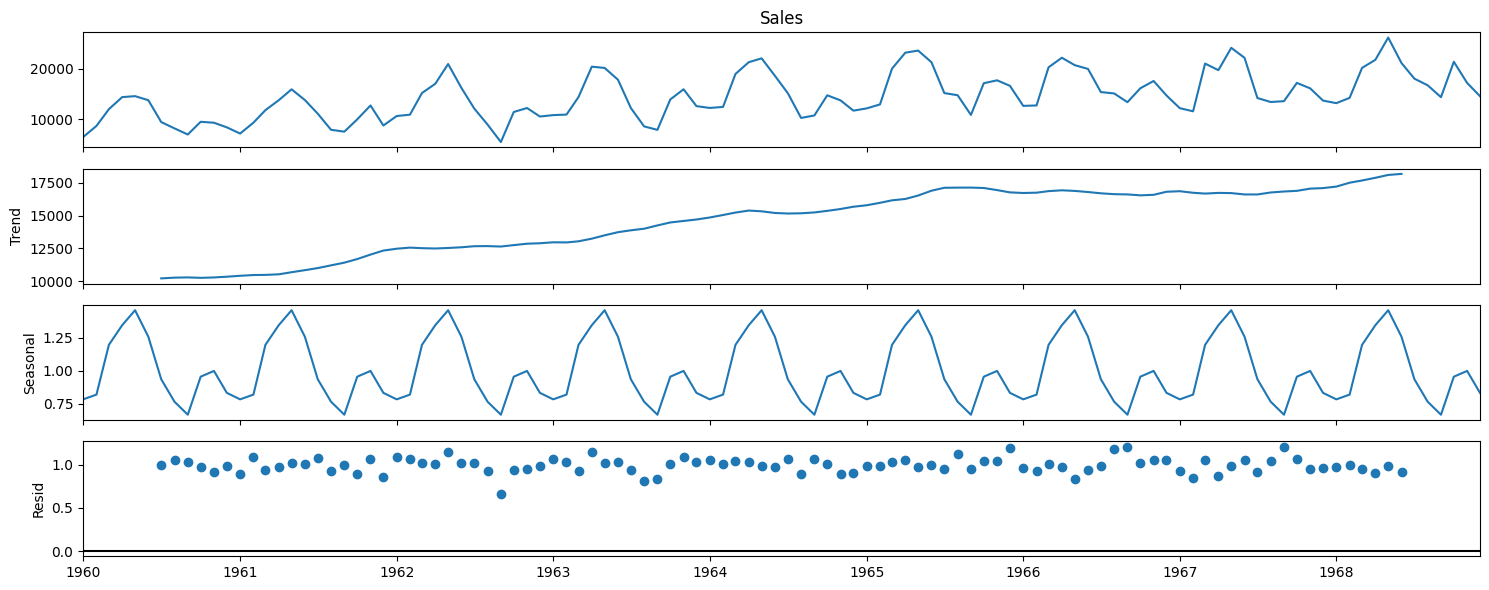

In [ ]:
df_decompose = sm.tsa.seasonal_decompose(df['Sales'], model="multiplicative", period=12)
df_decompose.plot()
plt.show()


In [ ]:
trend = df_decompose.trend
seasonal = df_decompose.seasonal
residual = df_decompose.resid

In [ ]:
print("Trend \n",trend.head(24))
print("Seasonal \n",seasonal.head(24))
print("Residual \n",residual.head(24))

Trend 
 Month
1960-01-01             NaN
1960-02-01             NaN
1960-03-01             NaN
1960-04-01             NaN
1960-05-01             NaN
1960-06-01             NaN
1960-07-01    10215.291667
1960-08-01    10270.833333
1960-09-01    10289.875000
1960-10-01    10256.541667
1960-11-01    10286.875000
1960-12-01    10343.916667
1961-01-01    10413.708333
1961-02-01    10470.750000
1961-03-01    10482.625000
1961-04-01    10525.583333
1961-05-01    10686.625000
1961-06-01    10843.083333
1961-07-01    11001.416667
1961-08-01    11210.291667
1961-09-01    11415.958333
1961-10-01    11690.500000
1961-11-01    12032.166667
1961-12-01    12338.750000
Name: trend, dtype: float64
Seasonal 
 Month
1960-01-01    0.782216
1960-02-01    0.818183
1960-03-01    1.194902
1960-04-01    1.343705
1960-05-01    1.457108
1960-06-01    1.256378
1960-07-01    0.934631
1960-08-01    0.764267
1960-09-01    0.665914
1960-10-01    0.953858
1960-11-01    0.997418
1960-12-01    0.831421
1961-01-01    0.7

In [ ]:
train=df[0:int(len(df)*0.80)]
test=df[int(len(df)*0.80):]
#Split the data for 21 month test

train_log = np.log10(train['Sales'])

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
model_df = ExponentialSmoothing(np.asarray(train['Sales']),seasonal_periods=24, trend='add',seasonal='mul').fit(optimized=True)

In [ ]:
df_Holt = test.copy()

In [ ]:
df_Holt['Holt']=model_df.forecast(len(test['Sales']))

In [ ]:
mean_absolute_percentage_error(test['Sales'],df_Holt['Holt'])

11.674390102710031

In [ ]:
model_df.params

{'smoothing_level': 0.32321428571428573,
 'smoothing_trend': 0.0001,
 'smoothing_seasonal': 0.1471273291925466,
 'damping_trend': nan,
 'initial_level': 10552.65694444444,
 'initial_trend': 111.40366161616225,
 'initial_seasons': array([0.87878393, 0.89101339, 1.28174152, 1.41684739, 1.58059808,
        1.2613537 , 0.9782187 , 0.68886514, 0.56486177, 0.91724536,
        0.90783089, 0.77225061, 0.75485929, 0.85262959, 1.08756336,
        1.38492694, 1.45564659, 1.26258518, 0.93337236, 0.65884791,
        0.61616496, 0.92727996, 1.10894654, 0.81756681]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

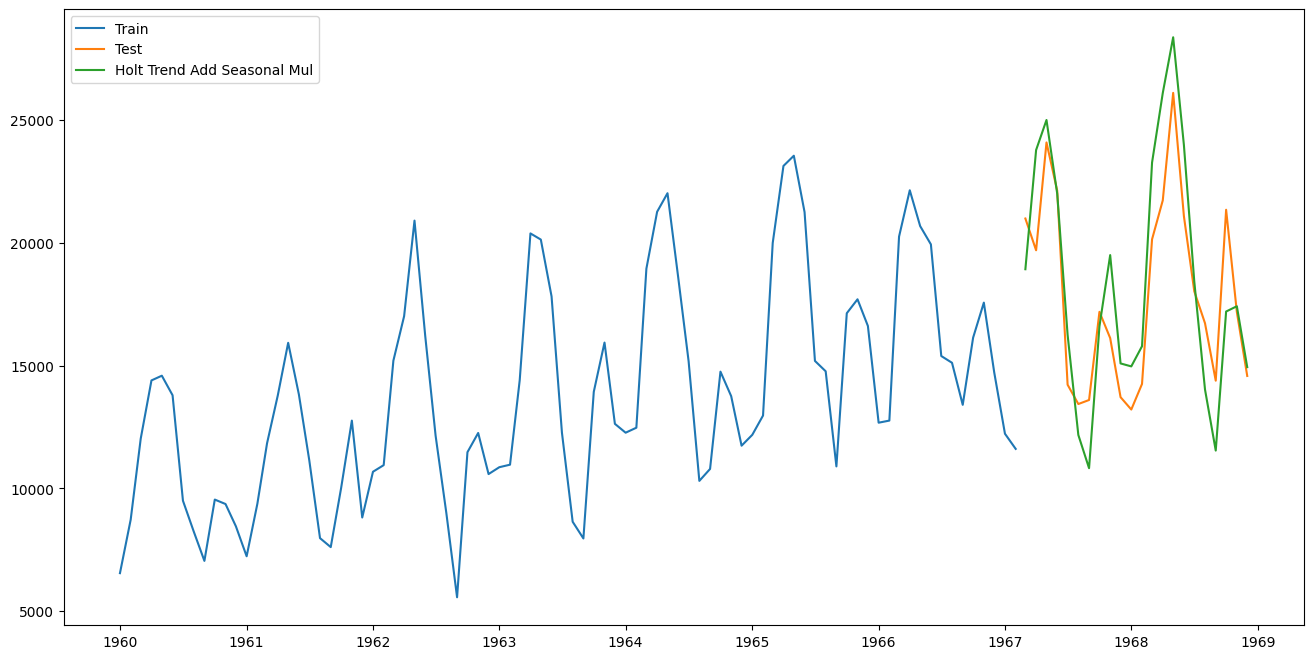

In [ ]:
df_Holt['data'] = model_df.forecast(len(test['Sales']))
plt.figure(figsize=(16,8))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(df_Holt['Holt'], label='Holt Trend Add Seasonal Mul')
plt.legend(loc=0)

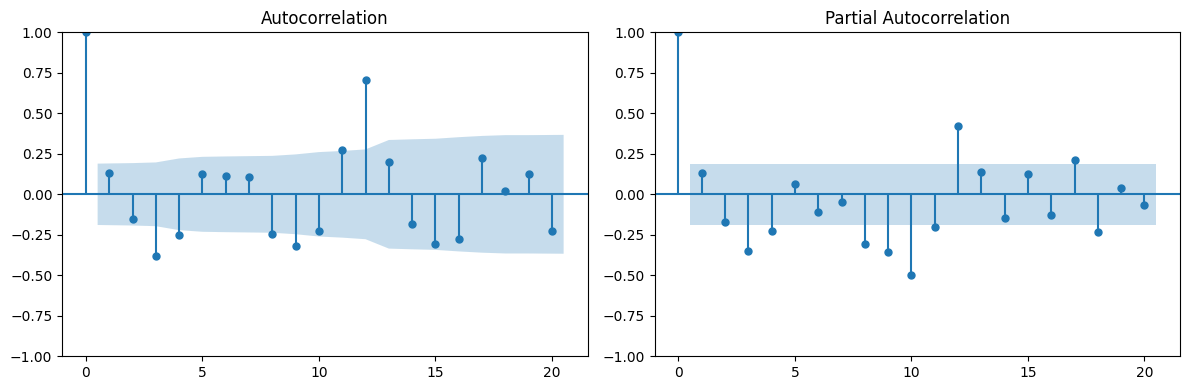

In [ ]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(diff_log_df, lags=20, ax=axes[0])
smt.graphics.plot_pacf(diff_log_df, lags=20, ax=axes[1])
plt.tight_layout()

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None
train_log = np.log10(train['Sales'])

In [ ]:
for param in pdq: #Non-Seasonal
    for param_seasonal in seasonal_pdq:

        try:
            temp_model = sm.tsa.statespace.SARIMAX(train_log,
                                             order = param,
                                             seasonal_order = param_seasonal)
            results = temp_model.fit()
            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal #Store the best param values : AIC, P, D, Q [Non-S / Seas]
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(1, 1, 1)x(1, 0, 1, 12)12 model - AIC:-234.14220602936575


In [ ]:
mod = sm.tsa.statespace.SARIMAX(train_log,
                                order=(0,1,1),
                                seasonal_order=(1,0,1,12),
                                enforce_stationarity=True)

best_results = mod.fit()

print(best_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7281      0.109     -6.659      0.000      -0.942      -0.514
ar.S.L12       0.9611      0.029     32.924      0.000       0.904       1.018
ma.S.L12      -0.4077      0.175     -2.328      0.020      -0.751      -0.064
sigma2         0.0028      0.000      7.487      0.000       0.002       0.003


In [ ]:
best_results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ma.L1,-0.7281,0.109,-6.659,0.000,-0.942,-0.514
ar.S.L12,0.9611,0.029,32.924,0.000,0.904,1.018
ma.S.L12,-0.4077,0.175,-2.328,0.020,-0.751,-0.064
sigma2,0.0028,0.000,7.487,0.000,0.002,0.003


In [ ]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('1967-01-01'), dynamic=True, full_results=True)

In [ ]:
pred_dynamic_ci = pred_dynamic.conf_int()

In [ ]:
pred99 = best_results.get_forecast(steps=24, alpha=0.1)

In [ ]:
# Extract the predicted and true values of our time series
sales_ts_forecasted = pred_dynamic.predicted_mean
testCopy = test.copy()
testCopy['Sales Forecast'] = np.power(10, pred99.predicted_mean)

In [ ]:
# Compute the root mean square error
mse = ((testCopy['Sales'] - testCopy['Sales Forecast']) ** 2).mean()
rmse = np.sqrt(mse)
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 3)))

The Root Mean Squared Error of our forecasts is 2152.03


In [ ]:
axis = train['Sales'].plot(label='Train Sales', figsize=(10, 6))
testCopy['Sales'].plot(ax=axis, label='Test Sales', alpha=0.7)
testCopy['Sales Forecast'].plot(ax=axis, label='Forecasted ', alpha=0.7)
axis.set_xlabel('Years')
axis.set_ylabel('Sales')
plt.legend(loc='best')
plt.show()
plt.close()

In [ ]:
# Get forecast 36 steps (3 years) ahead in future
n_steps = 36
pred_uc_99 = best_results.get_forecast(steps=36, alpha=0.01) # alpha=0.01 signifies 99% confidence interval
pred_uc_95 = best_results.get_forecast(steps=36, alpha=0.05) # alpha=0.05 95% CI

# Get confidence intervals 95% & 99% of the forecasts
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()

In [ ]:
n_steps = 36
idx = pd.date_range(df.index[-1], periods=n_steps, freq='MS')
fc_95 = pd.DataFrame(np.column_stack([np.power(10, pred_uc_95.predicted_mean), np.power(10, pred_ci_95)]),
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([np.power(10, pred_ci_99)]),
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all = fc_all[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']] # just reordering columns
fc_all.head()

,forecast,lower_ci_95,upper_ci_95,lower_ci_99,upper_ci_99
1968-12-01,19488.114876,15368.332081,24712.286241,15368.332081,24712.286241
1969-01-01,21736.055932,16993.942509,27801.443205,16993.942509,27801.443205
1969-02-01,21162.222164,16408.085594,27293.839026,16408.085594,27293.839026
1969-03-01,19757.908933,15196.219102,25688.953469,15196.219102,25688.953469
1969-04-01,15252.945394,11639.936881,19987.423091,11639.936881,19987.423091


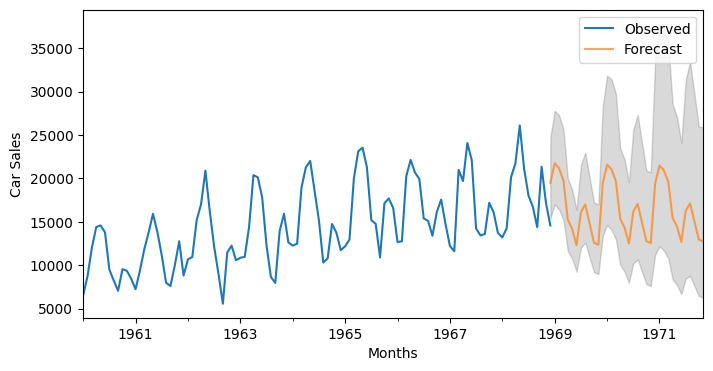

In [ ]:
# plot the forecast along with the confidence band
axis = df['Sales'].plot(label='Observed', figsize=(8, 4))
fc_all['forecast'].plot(ax=axis, label='Forecast', alpha=0.7)
axis.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color='k', alpha=.15)
axis.set_xlabel('Months')
axis.set_ylabel('Car Sales')
plt.legend(loc='best')
plt.show()

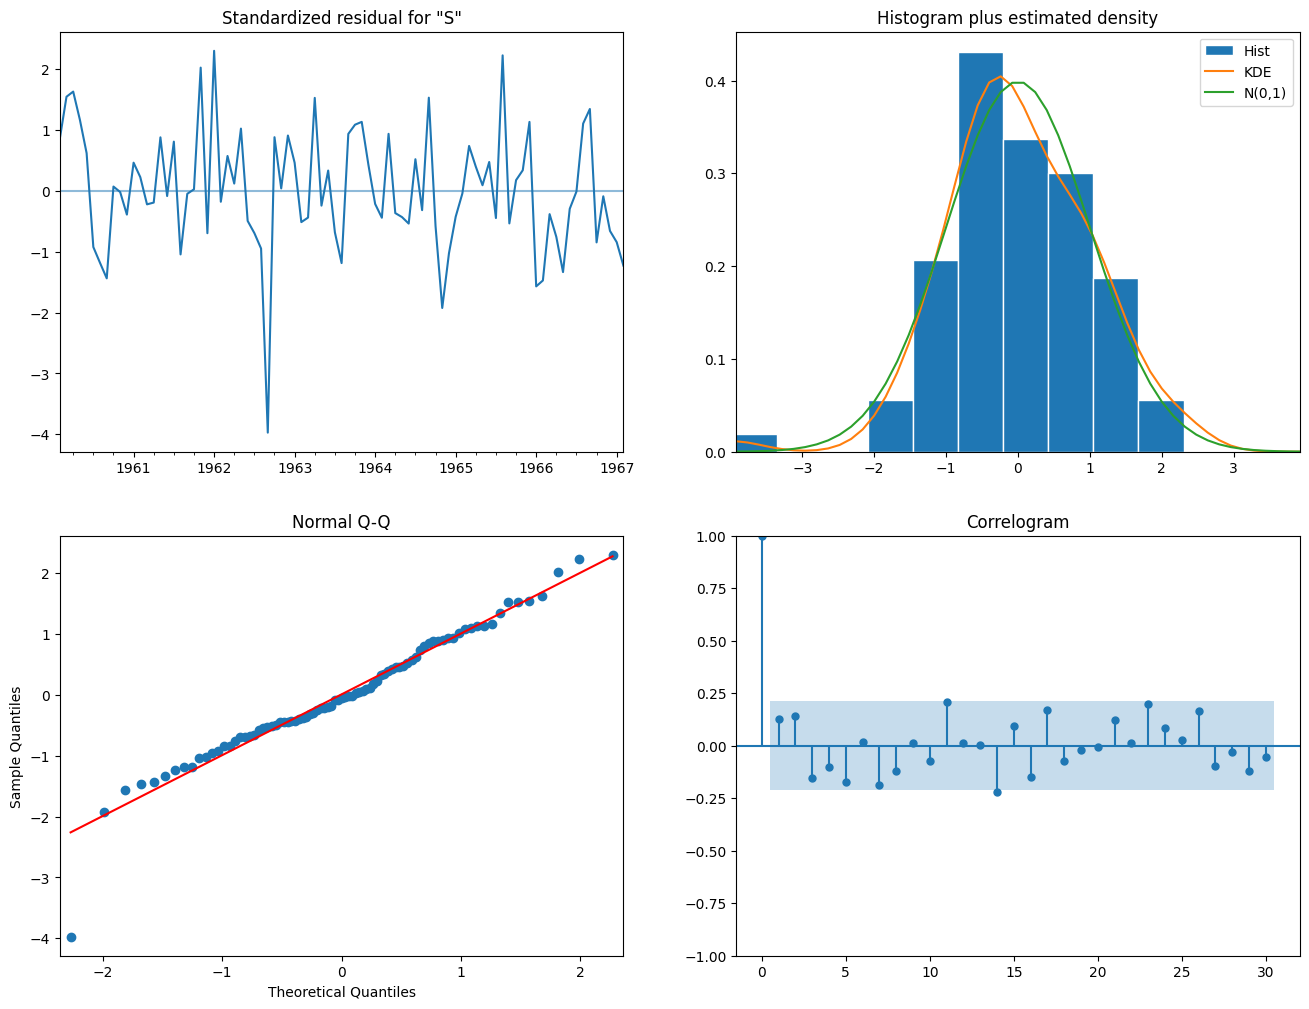

In [ ]:
best_results.plot_diagnostics(lags=30, figsize=(16,12))
plt.show()

In [ ]:
import statsmodels.api as sm

# Contoh: membuat dan fitting model SARIMAX
model = sm.tsa.SARIMAX(df, order=(0,1,1), seasonal_order=(1,0,1,12))
results = model.fit()

# Mendapatkan prediksi menggunakan get_forecast
forecast_steps = 25  # Ganti dengan jumlah langkah waktu yang diinginkan
forecast = results.get_forecast(steps=forecast_steps)

# Mendapatkan nilai prediksi
predicted_values = forecast.predicted_mean


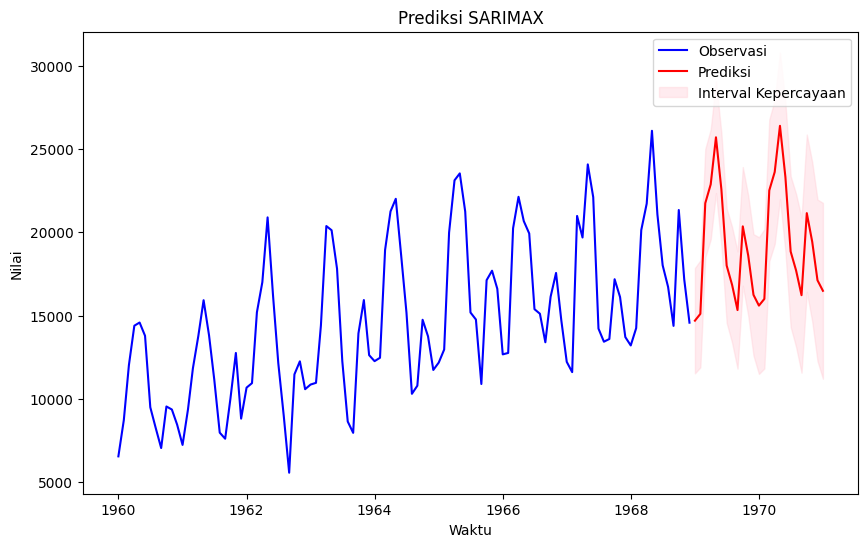

In [ ]:
# Mendapatkan interval kepercayaan
confidence_interval = forecast.conf_int()

# Memvisualisasikan hasil prediksi
plt.figure(figsize=(10, 6))

# Plot data observasi
plt.plot(df, label='Observasi', color='blue')

# Plot hasil prediksi
plt.plot(predicted_values, label='Prediksi', color='red')

# Plot interval kepercayaan
plt.fill_between(confidence_interval.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color='pink', alpha=0.3, label='Interval Kepercayaan')

# Menambahkan label dan judul
plt.xlabel('Waktu')
plt.ylabel('Nilai')
plt.title('Prediksi SARIMAX')
plt.legend()

# Menampilkan plot
plt.show()


In [ ]:
import pickle

In [ ]:
pickle.dump(model, open ('prediksi_sales.sav','wb'))